In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
# Add everything to our paths.
repo = "/pscratch/sd/m/mwhite/AnalyzeLAE/"
for codedir in ["odin","Cobaya/lss_likelihood"]:
    sys.path.append(repo+codedir)

In [3]:
import json
# Import the Class class.
from classy import Class
# Import velocileptors.
from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD
# Gamma function for wp(R).
from scipy.special import gamma
# Spline.
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

In [4]:
from fiducial import chi_dict
print(chi_dict)
#
fieldn      = "cosmos"
filter_name = "n419"
filter_name = "n501"
chi0 = chi_dict[filter_name.upper()]

{'N419': 3941.0, 'N501': 4448.0, 'N673': 5160.0}


## LAE clustering

Let's look at the clustering of LAEs in the mocks, using pre-generated data files created by AbacusHOD and theoretical predictions from Velocileptors.

In [5]:
lae = json.load(open("lae_"+filter_name+"_c000_ph100_s.json","r"))
Lbox= lae['BoxSize']
# Print some HOD information.  We will do the full list later.
print("# OmM={:.3f}, H0={:.2f}, z={:.2f}".format(lae['Omega_M'],lae['H0'],lae['Redshift']))
print("# Simulation box of side length {:.0f}Mpc/h.".format(Lbox))
print("# Have information for {:d} HODs.".format(len(lae['mocks'])))
print("# {:33s} {:>6s} {:>10s}".format('HOD params','fsat','nbar'))
for samp in lae['mocks'][:3]:
    hodstr = ""
    for p in samp['hod']: hodstr += " {:6.2f}".format(p)
    print(hodstr+" {:6.2f} {:10.2e}".format(samp['fsat'],samp['nobj']/Lbox**3))

# OmM=0.315, H0=67.36, z=3.00
# Simulation box of side length 1000Mpc/h.
# Have information for 198 HODs.
# HOD params                          fsat       nbar
  10.80  11.50   0.50   1.00   0.33   0.01   5.60e-02
  10.80  11.80   0.50   1.00   0.33   0.01   5.60e-02
  10.80  12.10   0.50   1.00   0.33   0.01   5.59e-02


### Linear theory

First set up the linear theory and background quantities for this cosmology using CLASS.

In [6]:
# Set up the class instance.
params = {
    'output': 'tCl lCl mPk',
    'l_max_scalars': 2000,
    'P_k_max_h/Mpc': 50.,
    'z_pk': '0.0,10',
    'lensing': 'yes',
    'A_s': np.exp(3.040)*1e-10,
    'n_s': 0.96824,
    'h': 0.6770,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'tau_reio': 0.0568,
    'omega_b': 0.022447,
    'omega_cdm': 0.11923}
# Now update some keys with N-body values.
for k in ['n_s','omega_b','omega_cdm',\
          'omega_ncdm','N_ncdm','N_ur']:
    params[k] = lae[k]
params['h'] = lae['H0']/100.0
#
cosmo = Class()
cosmo.set(params)
cosmo.compute()
#
wb = cosmo.omega_b()
wnu= params['omega_ncdm'] # wnu= 0.0106 * params['m_ncdm']
#
print("OmegaM=",cosmo.Omega_m())
print("sigma8=",cosmo.sigma8())
print("hubble=",cosmo.h())
print("omegab=",wb)
print("omegav=",wnu)
#
cosmo.get_current_derived_parameters(['H0','Omega_Lambda',\
                                      'age','conformal_age','Neff',\
                                      'z_reio','100*theta_s','rs_rec','rs_d'])

OmegaM= 0.3151917236639384
sigma8= 0.809091517562698
hubble= 0.6736
omegab= 0.02237
omegav= 0.0006442


{'H0': 67.36,
 'Omega_Lambda': 0.6847284676967347,
 'age': 13.797154912501444,
 'conformal_age': 14153.245737831245,
 'Neff': 3.045998221453431,
 'z_reio': 7.9332733154296875,
 '100*theta_s': 1.041847768993375,
 'rs_rec': 144.53105474921955,
 'rs_d': 147.0970465173836}

In [7]:
zz = lae['Redshift']
ff = cosmo.scale_independent_growth_factor_f(zz)
print("z={:.2f}, f={:.4f}".format(zz,ff))
#
hub= cosmo.h()                # To convert to "conventional" Mpc/h units.
kk = np.logspace(-4.0,1.5,1000)
pk = np.array( [cosmo.pk(k*hub,zz)*hub**3 for k in kk] )
pl = np.array( [cosmo.pk_lin(k*hub,zz)*hub**3 for k in kk] )
#
# Compute the Zeldovich displacement and hence k_{nl}.
knl= 1/np.sqrt( np.trapz(pl,x=kk)/6./np.pi**2 )
print("knl=",knl," h/Mpc.")

z=3.00, f=0.9786
knl= 0.5423896725428068  h/Mpc.


Text(0, 0.5, '$P(k)\\quad [h^{-3}{\\rm Mpc}^3]$')

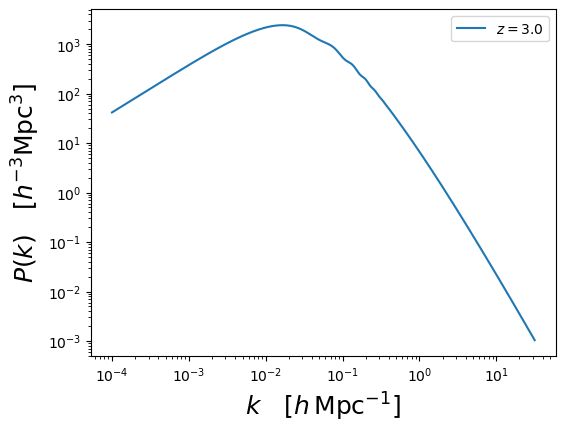

In [8]:
fig,ax = plt.subplots(1,1,figsize=(6,4.5))
ax.plot(kk,pk,label="$z={:.1f}$".format(zz))
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k\quad [h\,{\rm Mpc}^{-1}]$',fontsize=18)
ax.set_ylabel(r'$P(k)\quad [h^{-3}{\rm Mpc}^3]$',fontsize=18)

### Compare with the N-body data


In [9]:
# Copy the N-body data into a single array.
# (Can also read ihod from our _mod.json file)
ihod=34 # z=2.5
ihod=41 # z=3.0
samp=lae['mocks'][ihod]

and compute the projected clustering for one of our models.

In [10]:
from predict_wR import NbodyCorrelationFunctions,ThinShellWR
#
ximod = NbodyCorrelationFunctions("lae_"+filter_name+"_c000_ph100_s.json")
thy   = ThinShellWR(ximod,chi0,"lae_"+fieldn+"_"+filter_name.upper()+"_sfn.txt")
#
Rs    = [0.6,0.8,1.,2.,3.,4.,5.,8.,10.,12.5,15.,20.]
wofR  = thy(Rs,ihod)
print(Rs)
print(wofR)

[0.6, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0, 8.0, 10.0, 12.5, 15.0, 20.0]
[0.6283009  0.54429636 0.48703994 0.33974185 0.26799598 0.22214991
 0.18946692 0.12816224 0.10277808 0.08007279 0.06392334 0.04279704]


A figure showing the clustering.

In [11]:
dd   = np.loadtxt("mc_"+fieldn+"_"+filter_name.upper()+"_wR.txt")
corr = np.zeros( (dd.shape[0],dd.shape[0]) )
fin  = open("mc_"+fieldn+"_"+filter_name.upper()+"_wR.txt","r")
inp  = "# Dummy"
while not inp.startswith("# Correlation matrix"):
    inp = fin.readline()
for i in range(dd.shape[0]):
    inp = fin.readline()[1:]
    xx  = [float(x) for x in inp.split()]
    for j in range(dd.shape[0]):
        corr[i,j] = xx[j]
cov = np.zeros_like(corr)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        cov[i,j]=dd[i,2]*corr[i,j]*dd[j,2]
err = np.sqrt(np.diag(cov))

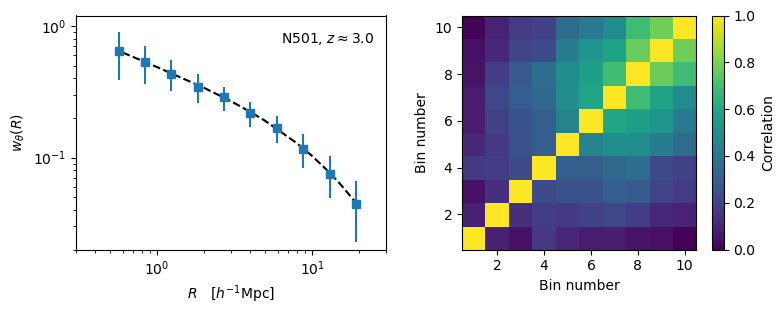

In [12]:
fig,ax = plt.subplots(1,2,figsize=(8,3.25))
#
ax[0].errorbar(dd[:,0],dd[:,1],yerr=err,fmt='s')
ax[0].plot(Rs,wofR,'k--')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(0.3,30.)
ax[0].set_ylim(0.02,1.2)
ax[0].set_xlabel(r'$R\quad [h^{-1}{\rm Mpc}]$')
ax[0].set_ylabel(r'$w_\theta(R)$')
ax[0].text(25.0,0.8,filter_name.upper()+\
           r', $z\approx '+'{:.1f}'.format(zz)+'$',\
           ha='right',va='center')
#
cax = ax[1].imshow(corr,origin='lower',vmin=0,vmax=1,\
                   extent=[0.5,corr.shape[0]+0.5,0.5,corr.shape[1]+0.5])
ax[1].set_aspect('equal')
ax[1].set_xlabel(r'Bin number')
ax[1].set_ylabel(r'Bin number')
bar = plt.colorbar(cax)
bar.set_label('Correlation')
#
plt.tight_layout()
plt.savefig('lae_mock_'+fieldn+'_'+filter_name.upper()+'_wR.png')
plt.savefig('lae_mock_'+fieldn+'_'+filter_name.upper()+'_wR.pdf')

# Done